In [1]:
# Imports
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

import time

In [2]:
# Hyperparameters definition
BATCH_SIZE = 256
EPOCH = 100
PATIENCE = 10
ACTIVATION = 'relu'
FINAL_LAYER_ACTIVATION = 'softmax'
OPTIMIZER = 'adam'
METRIC = ['accuracy']
LOSS_FUNCTION = 'categorical_crossentropy'

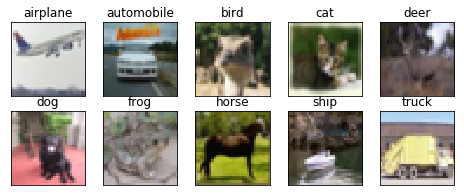

In [3]:
# Load CIFAR-10 data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Plot some examples of the classes
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    rnd_img = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[rnd_img,::], (0, 1, 2))
    plt.imshow(im)
plt.show()

In [4]:
# Data pre-processing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0


Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

In [5]:
#Functoin to plot the model history, losses and accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [8]:
# Model Feed Forward Neural Net
def init_model(optimizer = 'adam'):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation=ACTIVATION,
                     input_shape=(32, 32, 3)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation=ACTIVATION))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation=ACTIVATION))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # model.add(Dense(1024, activation=ACTIVATION))
    model.add(Dense(10, activation=FINAL_LAYER_ACTIVATION))
    
    model.compile(loss=LOSS_FUNCTION, optimizer=optimizer, metrics=METRIC)
    print('Model compield')
    return model

Model compield
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090 

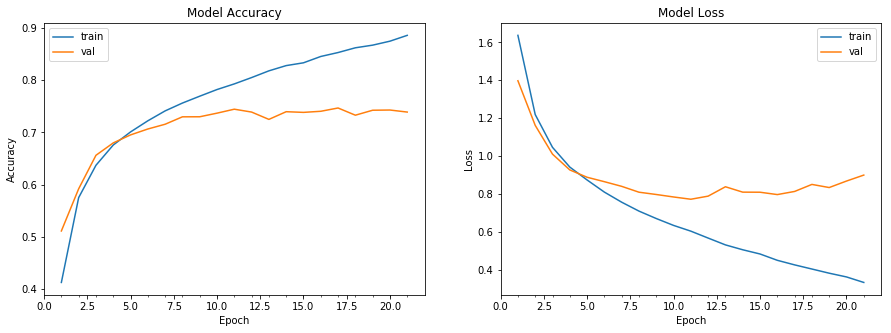

Training took 4507.793078660965 seconds


In [9]:
# Initialize the model and pritn its features
model = init_model()
print(model.summary())

# Define the early stopping condition
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)

# Train the model
start = time.time()
history = model.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCH, 
                    verbose=1, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[es])

end = time.time()

# Print the metrics in the testing set
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

# Plot the training graphicss
plot_model_history(history)
print("Training took " + str(end - start) + " seconds")

As shown in the graphics, there is a clear overfitting, but it'll be solved when using regularization

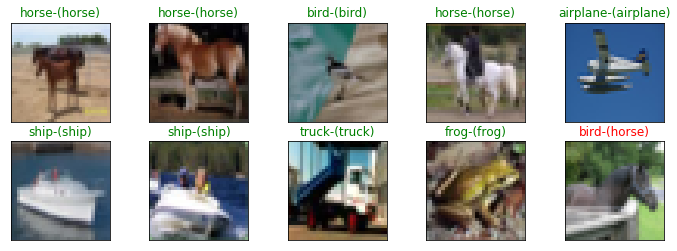

In [10]:
# Plot some random predictions

choices = [np.random.randint(10000) for _ in range(10)]
predictions = model.predict_classes(X_test)


fig = plt.figure(figsize=(12,4))
for i,idx in enumerate(choices):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    
    if predictions[idx] == y_test[idx][0]:
        color='green'
    else:
        color = 'red'
    ax.set_title('{}-({})'.format(class_names[predictions[idx]], class_names[y_test[idx][0]]), color=color)
    
    im = np.transpose(X_test[idx,::], (0, 1, 2))
    plt.imshow(im)
plt.show()

In [12]:
model.save('./cnn_model.h5')

# serialize model to JSON
model_json = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("cnn_model_weights.h5")
print("Saved model to disk")

Saved model to disk
